I realized I can't use the test boxes to do fixed cosmology optimization. They'll also be small enough to do in a notebook. So I'll do them here. 

In [65]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [66]:
from pearce.emulator import LemonPepperWet, NashvilleHot
from itertools import product
from GPy.kern import *
import numpy as np
from os import path
from sys import argv
import h5py
from time import time

In [67]:
#training_file ='/home/users/swmclau2/scratch/Aemulators/xi_zheng07_box0/PearceXiCosmo.hdf5'
training_file ='/home/users/swmclau2/scratch/Aemulators/vdf_zheng07_box0/PearceVDFCosmo_peaked.hdf5'

In [68]:
with h5py.File(training_file, 'r') as f:
    HOD_params = len(f.attrs['hod_param_names'])

In [69]:
fixed_params = {'z':0.0, 'cosmo':0}

In [70]:
HOD_kernels = [Matern32(input_dim=HOD_params, ARD=True)+\
               RBF(input_dim=HOD_params, ARD=True)]# + Bias(input_dim=HOD_params)]
               #RBF(input_dim=HOD_params, ARD=True) + Linear(input_dim=HOD_params, ARD=True) + Bias(input_dim=HOD_params), 
               #Matern32(input_dim=HOD_params, ARD=True)+RBF(input_dim=HOD_params, ARD=True) + Bias(input_dim=HOD_params)]#, RBF(input_dim=HOD_params, ARD=True) + Matern32(input_dim=HOD_params, ARD=True)]


radial_kernels = [RBF(input_dim=1, ARD=True)]# + Bias(input_dim=1)]
                  #Linear(input_dim=1, ARD=True) + RBF(input_dim=1, ARD=True) +Bias(input_dim=1)]
                  #Matern32(input_dim=7, ARD=True)+RBF(input_dim=7, ARD=True) + Bias(input_dim=7)]


In [71]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    denom = np.outer(std, std)
    return cov/denom

In [72]:
best_acc = np.inf
#best_idxs = None

In [73]:
#for j, hk in enumerate(HOD_kernels):
#    for k, rk in enumerate(radial_kernels):
hyperparams = {'kernel': [ HOD_kernels[0], radial_kernels[0]] , \
               'optimize':  True}

In [74]:
np.random.seed(0)
emu = LemonPepperWet(training_file, hyperparams=hyperparams,\
                     fixed_params = fixed_params,\
                     downsample_factor = 1.0 )

 /home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:2832: UserWarning:WARNING: NaN detected. Skipped 0 points in training data.


Optimization restart 1/5, f = -1467.66166816
Optimization restart 2/5, f = -706.380087464
Optimization restart 3/5, f = -1349.8523435
Optimization restart 4/5, f = 6024.81189644
Optimization restart 5/5, f = -1326.33158286


In [75]:
with h5py.File(training_file, 'r') as f:
    #f.attrs['rel_emu_cov'] = rel_cov
    shot_cov = f['cosmo_no_00']['a_1.000']['cov'][()]
    obs = f['cosmo_no_00']['a_1.000']['obs'][()]

In [76]:
obs.shape

(200, 20)

In [77]:
rel_covs = np.array([shot_cov[i]/np.outer(obs[i], obs[i]) for i in xrange(obs.shape[0])])

In [78]:
rc = rel_covs.mean(axis=0)

In [79]:
corr_mat = cov_to_corr(rc)

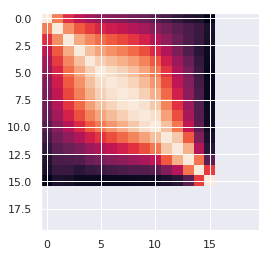

In [80]:
plt.imshow(corr_mat)

In [85]:
emu.scale_bin_centers

array([ 0.57715889,  0.7521343 ,  0.98015643,  1.27730729,  1.66454443,
        2.16917901,  2.82680202,  3.68379447,  4.80059857,  6.25598058,
        8.15258606, 10.62417931, 13.84507753, 18.04244507, 23.51231502,
       30.64046783, 39.92963975, 52.03497999, 67.81025724, 88.36807447])

In [81]:
with h5py.File(training_file) as f:
    f.attrs['rel_cov'] = rc

In [82]:
fiducial_hod = {'sigma_logM':0.2, 'logM0': 13.0, 'logM1': 14.0,
                'alpha':1.0,'conc_gal_bias': 1.0,\
                'mean_occupation_centrals_assembias_param1': 0.0,
               'mean_occupation_satellites_assembias_param1': 0.0}

In [83]:
xi = emu.emulate_wrt_r(fiducial_hod).squeeze()

In [86]:
from pearce.mocks.kittens import TrainingBox

In [87]:
cat = TrainingBox(0, system='sherlock')

In [88]:
cat.load(1.0, HOD='hsabZheng07')

In [89]:
cat.populate(fiducial_hod)

In [90]:
r_bins = np.logspace(-0.3, 2.0, 21)

In [91]:
xi = cat.calc_xi(r_bins)

In [93]:
vdf = cat.calc_vdf(r_bins, n_ran = 100)

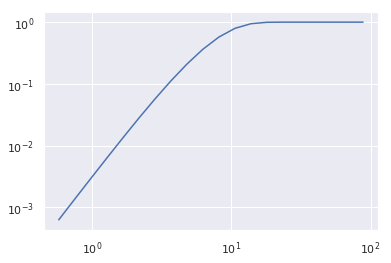

In [95]:
plt.plot(emu.scale_bin_centers, vdf)
plt.loglog();

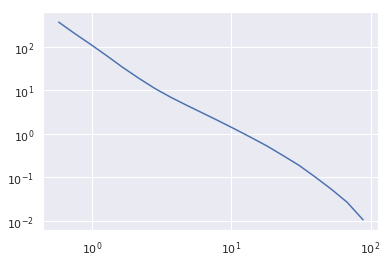

In [96]:
plt.plot(emu.scale_bin_centers, xi)
plt.loglog();